In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.esn import ESN
from adjoint_esn.rijke_esn import RijkeESN
from adjoint_esn.utils import preprocessing as pp
from adjoint_esn.utils.enums import eParam, get_eVar
from pathlib import Path
from adjoint_esn.utils import signals as sig
import adjoint_esn.utils.visualizations as vis
from adjoint_esn.utils import errors
from scipy import signal
from functools import partial
import yaml
from adjoint_esn.validation import set_ESN
from adjoint_esn.utils.discretizations import finite_differences
import adjoint_esn.utils.solve_ode as solve_ode

## Load config

In [2]:
def load_config(experiment_path):
       with open(experiment_path/'config.yml', 'r') as file:
         config = yaml.unsafe_load(file)
         return config

experiment_path=Path('../local_results/rijke/run_20231029_153121') # no noise

config = load_config(experiment_path)
results = pp.unpickle_file(experiment_path / 'results.pickle')[0]
print(config)
print(results)

model:
  connectivity: 20
  input_only_mode: false
  input_vars: eta_mu_v_tau
  input_weights_mode: sparse_grouped_rijke
  network_dt: 0.01
  output_vars: eta_mu
  param_vars:
  - beta
  r2_mode: false
  reservoir_size: 1200
  reservoir_weights_mode: erdos_renyi1
  type: rijke
  u_f_order: 1
  washout_time: 4
random_seed: 41
simulation:
  N_g: 4
  beta_list:
  - 1.0
  - 2.0
  - 3.0
  - 4.0
  - 5.0
  noise_level: 0
  sim_dt: 0.001
  sim_time: 800
  tau_list:
  - 0.1
  - 0.15
  - 0.2
  - 0.25
  - 0.3
  transient_time: 200
train:
  regime_selection: 20
  tikhonov: 0.001
  time: 8
val:
  error_measure: rel_L2
  fold_time: 4
  hyperparameters:
    input_scaling:
      max: 5.0
      min: 0.01
      scale: log10
    leak_factor:
      max: 1.0
      min: 0.01
      scale: log10
    parameter_normalization_mean:
      beta:
        max: 10.0
        min: -10.0
        scale: uniform
    parameter_normalization_var:
      beta:
        max: 10.0
        min: 0.01
        scale: log10
    spect

## Generate clean data

In [3]:
integrator = 'odeint'

# number of galerkin modes
N_g = config.simulation.N_g

# simulation options
sim_time = config.simulation.sim_time
sim_dt = config.simulation.sim_dt

# directory to search for simulation data, if the data doesn't exist, 
# then it will simulate the system
data_dir=Path('..\data')

# which regimes to use for training and validation
train_param_list = results["training_parameters"]
train_idx_list = np.arange(len(train_param_list))

transient_time = config.simulation.transient_time

# network time step
network_dt = config.model.network_dt

washout_time = config.model.washout_time

# which states to use as input and output
# for standard ESN these should be the same, e.g. both 'eta_mu'
# for Rijke ESN, input and output should be 'eta_mu_v_tau' and 'eta_mu' respectively
input_vars = config.model.input_vars
eInputVar = get_eVar(input_vars,N_g)
output_vars = config.model.output_vars
eOutputVar = get_eVar(output_vars,N_g)

# which system parameter is passed to the ESN
param_vars=config.model.param_vars

# if using Rijke ESN what is the order of u_f(t-tau) in the inputs,
# [u_f(t-tau), u_f(t-tau)^2 ..., u_f(t-tau)^(u_f_order)]
u_f_order = config.model.u_f_order

# length of training time series
train_time = config.train.time
val_time = config.train.time

loop_names=['train']
loop_times = [train_time]

DATA_clean = {}
for loop_name in loop_names:
    DATA_clean[loop_name]={'u_washout':[],'p_washout':[],'u':[],'p':[],'y':[],'t':[]}

for p_idx, p in enumerate(train_param_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir,integrator=integrator)

    regime_data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        loop_names=loop_names,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order,
                        noise_level=0.0,
                        tau=p_sim["tau"])
    
    for loop_name in loop_names:
        [DATA_clean[loop_name][var].append(regime_data[loop_name][var]) for var in DATA_clean[loop_name].keys()]

dim = DATA_clean["train"]["u"][0].shape[1]

## Generate noisy data

In [4]:
noise_level = 5.0
n_seeds = 100

DATA_list = [None]*n_seeds
for s_idx in range(n_seeds):
    DATA_list[s_idx] = {}
    for loop_name in loop_names:
        DATA_list[s_idx][loop_name]={'u_washout':[],'p_washout':[],'u':[],'p':[],'y':[],'t':[]}

for p_idx, p in enumerate(train_param_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir,integrator=integrator)

    for s_idx in range(n_seeds):
        regime_data = pp.create_dataset(y_sim,t_sim,p_sim,
                            network_dt=network_dt,
                            transient_time=transient_time,
                            washout_time=washout_time,
                            loop_times=loop_times,
                            loop_names=loop_names,
                            input_vars=input_vars,
                            output_vars=output_vars,
                            param_vars=param_vars,
                            N_g=N_g,
                            u_f_order=u_f_order,
                            noise_level=noise_level,
                            random_seed=None,
                            tau=p_sim["tau"])
        
        for loop_name in loop_names:
            [DATA_list[s_idx][loop_name][var].append(regime_data[loop_name][var]) for var in DATA_list[s_idx][loop_name].keys()]


## Train with clean

In [5]:
def create_ESN(ESN_dict, model_type, hyp_param_names, hyp_param_scales, hyp_params):
    if model_type == 'standard':
        my_ESN = ESN(**ESN_dict)
    elif model_type == 'rijke':
        my_ESN = RijkeESN(**ESN_dict)
    set_ESN(my_ESN,hyp_param_names,hyp_param_scales,hyp_params)
    return my_ESN

ESN_dict = {
        "reservoir_size": config.model.reservoir_size,
        "parameter_dimension": len(param_vars),
        "reservoir_connectivity": config.model.connectivity,
        "r2_mode": config.model.r2_mode,
        "input_only_mode": config.model.input_only_mode,
        "input_weights_mode": config.model.input_weights_mode,
        "reservoir_weights_mode": config.model.reservoir_weights_mode,
        "tikhonov": config.train.tikhonov,
        "verbose":False
    }
if config.model.type == "standard":
    ESN_dict["dimension"] = dim
elif config.model.type == "rijke":
    ESN_dict["N_g"] = config.simulation.N_g
    ESN_dict["x_f"] = 0.2
    ESN_dict["dt"] = config.model.network_dt
    ESN_dict["u_f_order"] = config.model.u_f_order

print('System dimension: ', dim)

top_idx = 0
hyp_param_names = []
hyp_params = []
for name in results.keys():
    if name not in ['training_parameters','validation_parameters','f','tikh']:
        if results[name].ndim == 2:
            hyp_param_names.extend([name]*results[name].shape[1])
            hyp_params.extend(results[name][top_idx])
        elif results[name].ndim == 1:
            hyp_param_names.extend([name])
            hyp_params.extend([results[name][top_idx]])
        
hyp_param_scales = ['uniform']*len(hyp_param_names)
# expand the ESN dict with the fixed seeds
ESN_dict["input_seeds"] = [20,21,22]
ESN_dict["reservoir_seeds"] = [23,24]
my_ESN_clean = create_ESN(ESN_dict, config.model.type, hyp_param_names, hyp_param_scales, hyp_params)
my_ESN_clean.train(DATA_clean["train"]["u_washout"], 
             DATA_clean["train"]["u"], 
             DATA_clean["train"]["y"],
             P_washout=DATA_clean["train"]["p_washout"], 
             P_train=DATA_clean["train"]["p"],
             train_idx_list=train_idx_list)
W_out_clean = my_ESN_clean.W_out

System dimension:  9


## Train with noisy

In [6]:
W_out_list = [None]*n_seeds
for s_idx in range(n_seeds):
    my_ESN = create_ESN(ESN_dict, config.model.type, hyp_param_names, hyp_param_scales, hyp_params)
    my_ESN.train(DATA_list[s_idx]["train"]["u_washout"], 
                DATA_list[s_idx]["train"]["u"], 
                DATA_list[s_idx]["train"]["y"],
                P_washout=DATA_list[s_idx]["train"]["p_washout"], 
                P_train=DATA_list[s_idx]["train"]["p"],
                train_idx_list=train_idx_list)
    W_out_list[s_idx] = my_ESN.W_out
W_out_list = np.array(W_out_list)

In [79]:
W_out_list = [None]*n_seeds
for s_idx in range(n_seeds):
    my_ESN = create_ESN(ESN_dict, config.model.type, hyp_param_names, hyp_param_scales, hyp_params)
    my_ESN.train(DATA_clean["train"]["u_washout"], 
                DATA_clean["train"]["u"], 
                DATA_list[s_idx]["train"]["y"],
                P_washout=DATA_clean["train"]["p_washout"], 
                P_train=DATA_clean["train"]["p"],
                train_idx_list=train_idx_list)
    W_out_list[s_idx] = my_ESN.W_out
W_out_list = np.array(W_out_list)

## Compare statistics of noisy $W_{out}$ with clean $W_{out}$

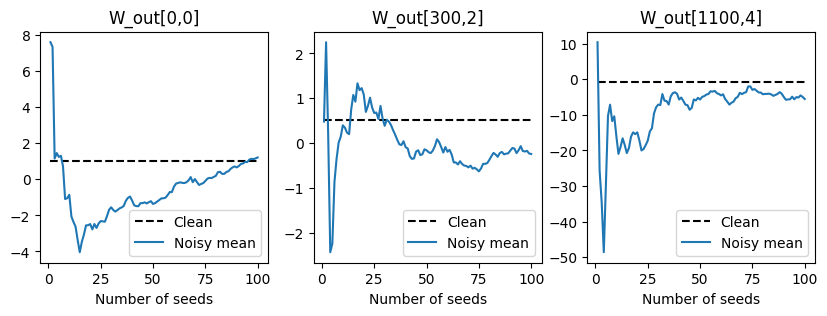

In [82]:
r_idxs = [0,300,1100]
y_idxs = [0, 2, 4]
i = 0
plt.figure(figsize=(10,3))
for r_idx, y_idx in zip(r_idxs,y_idxs):
    i += 1
    plt.subplot(1,3,i)
    W_out_cum = (1/np.arange(1,n_seeds+1)) * np.cumsum(W_out_list[:,r_idx,y_idx])
    plt.hlines(W_out_clean[r_idx,y_idx], xmin=1, xmax=n_seeds, color='k', linestyle='--')
    plt.plot(np.arange(1,n_seeds+1),W_out_cum)
    plt.xlabel('Number of seeds')
    plt.title(f'W_out[{r_idx},{y_idx}]')
    plt.legend(['Clean','Noisy mean'],loc='lower right')

In [83]:
W_out_mean = np.mean(W_out_list,axis=0)
W_out_std = np.std(W_out_list,axis=0)

In [84]:
print(f"Clean W_out[{r_idx},{y_idx}]: {W_out_clean[r_idx,y_idx]}")
print(f"Mean W_out[{r_idx},{y_idx}]: {W_out_mean[r_idx,y_idx]}")
print(f"Std W_out[{r_idx},{y_idx}]: {W_out_std[r_idx,y_idx]}")

Clean W_out[1100,4]: -0.7336045139043427
Mean W_out[1100,4]: -5.534165470311626
Std W_out[1100,4]: 45.91446283336094


In [85]:
R = np.empty((0, my_ESN_clean.W_out_shape[0]))
for train_idx in train_idx_list:
    X_train_augmented_ = my_ESN_clean.reservoir_for_train(
        DATA_clean["train"]["u_washout"][train_idx],
        DATA_clean["train"]["u"][train_idx],
        DATA_clean["train"]["p_washout"][train_idx],
        DATA_clean["train"]["p"][train_idx],
    )
    R = np.vstack((R, X_train_augmented_))

In [86]:
Y_train = [DATA_clean["train"]["y"][train_idx] for train_idx in train_idx_list]
Y_train = np.vstack(Y_train)

In [87]:
# get the standard deviation of noise
std_list = np.zeros((len(train_idx_list),DATA_clean["train"]["y"][0].shape[1]))
for train_idx in train_idx_list:
    std_list[train_idx] = noise_level/100*np.std(DATA_clean["train"]["y"][train_idx],axis=0)
# this is different for each regime
# we need to concatenate and make a diagonal matrix

In [88]:
y_idx = 0
epsilon = np.diag(np.repeat(std_list[:,y_idx]**2,DATA_clean["train"]["y"][0].shape[0]))

RR = np.matmul(R.T,R)
phi = RR+my_ESN_clean.tikhonov*np.eye(my_ESN_clean.N_reservoir)
f = np.matmul(R.T, Y_train)
cov1 = np.linalg.solve(phi,R.T)
cov = cov1 @ epsilon @ cov1.T

# cov12 = np.linalg.inv(phi)
# cov2 = cov12 @ R.T @ epsilon @ R @ cov12

W_out_cov = np.cov(W_out_list[:,:,y_idx].T)

Text(0.5, 0, 'Output state')

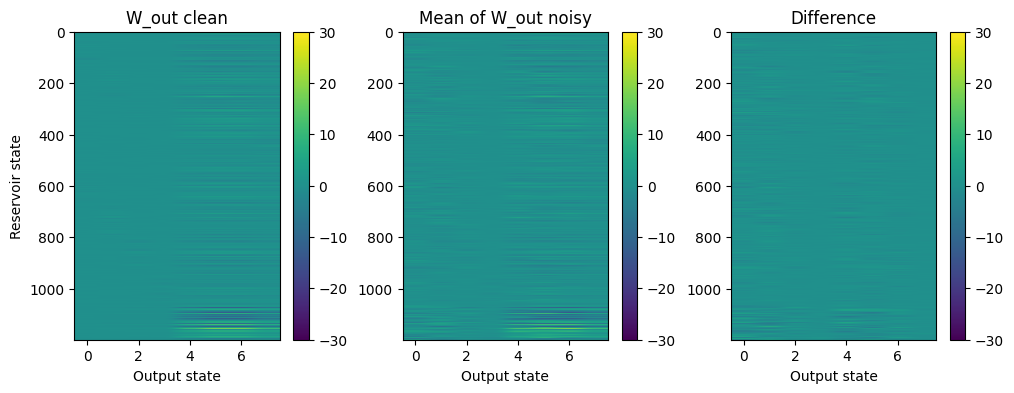

In [89]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(W_out_clean, aspect=0.01, vmin=-30, vmax=30)
plt.colorbar()
plt.title("W_out clean")
plt.ylabel('Reservoir state')
plt.xlabel('Output state')
plt.subplot(1,3,2)
plt.imshow(W_out_mean, aspect=0.01, vmin=-30, vmax=30)
plt.colorbar()
plt.title("Mean of W_out noisy")
plt.xlabel('Output state')
plt.subplot(1,3,3)
plt.imshow(W_out_clean-W_out_mean, aspect=0.01, vmin=-30, vmax=30)
plt.colorbar()
plt.title("Difference")
plt.xlabel('Output state')

Text(0.5, 0, 'Reservoir state')

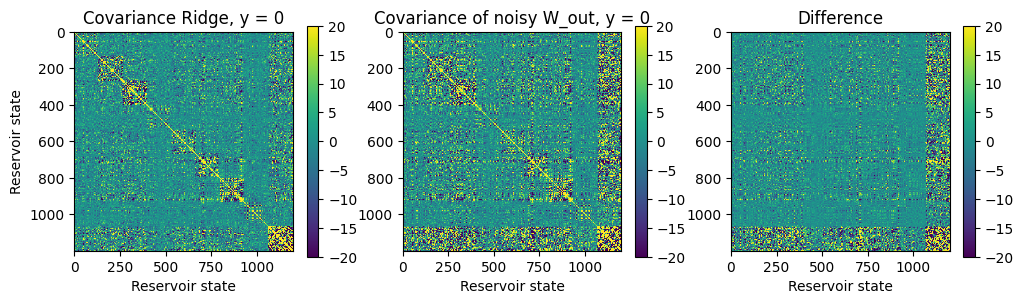

In [90]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.imshow(cov,vmin=-20,vmax=20)
plt.colorbar()
plt.title(f'Covariance Ridge, y = {y_idx}')
plt.xlabel('Reservoir state')
plt.ylabel('Reservoir state')
plt.subplot(1,3,2)
plt.imshow(W_out_cov,vmin=-20,vmax=20)
plt.colorbar()
plt.title(f'Covariance of noisy W_out, y = {y_idx}')
plt.xlabel('Reservoir state')
plt.subplot(1,3,3)
plt.imshow(cov-W_out_cov,vmin=-20,vmax=20)
plt.colorbar()
plt.title('Difference')
plt.xlabel('Reservoir state')

## Estimating noise

In [91]:
r_clean = my_ESN_clean.open_loop(x0 = np.zeros(my_ESN_clean.N_reservoir),
                                U = DATA_clean["train"]["u"][train_idx],
                                P = DATA_clean["train"]["p"][train_idx])

In [ ]:
v1 = (1-my_ESN_clean.alpha)*np.eye(my_ESN_clean.N_reservoir)+my_ESN_clean.alpha*my_ESN_clean.W.toarray()
v2 = my_ESN_clean.alpha*my_ESN_clean.W_in.toarray()[:,:-my_ESN_clean.N_param_dim]
v = np.zeros((n_seeds,len(r_clean),my_ESN_clean.N_reservoir))
for s_idx in range(n_seeds):
    e = DATA_clean["train"]["u"][train_idx]-DATA_list[s_idx]["train"]["u"][train_idx]
    for i in np.arange(1,len(r_clean)):
        v[s_idx,i,:] = v1 @ v[s_idx,i-1] + v2 @ e[i-1]

In [72]:
v_true = np.zeros((n_seeds,len(r_clean),my_ESN_clean.N_reservoir))
for s_idx in range(n_seeds):
    r_noisy = my_ESN_clean.open_loop(x0 = np.zeros(my_ESN_clean.N_reservoir),
                                U = DATA_list[s_idx]["train"]["u"][train_idx],
                                P = DATA_list[s_idx]["train"]["p"][train_idx])
    v_true[s_idx] = r_clean-r_noisy

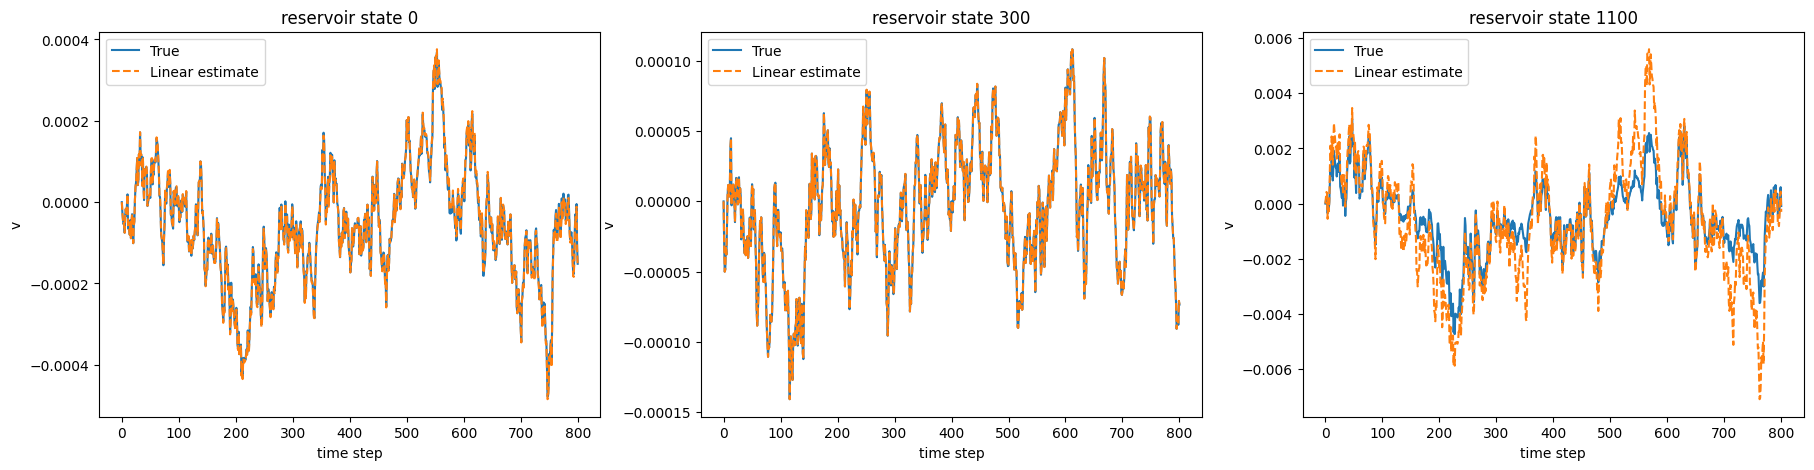

In [71]:
# compare linear noise estimation with the true
s_idx = 0
r_noisy = my_ESN_clean.open_loop(x0 = np.zeros(my_ESN_clean.N_reservoir),
                                U = DATA_list[s_idx]["train"]["u"][train_idx],
                                P = DATA_list[s_idx]["train"]["p"][train_idx])
r_idxs = [0, 300, 1100]
i = 0
plt.figure(figsize=(22,5))
for r_idx in r_idxs:
    i += 1
    plt.subplot(1,3,i)
    plt.plot(r_clean[:,r_idx]-r_noisy[:,r_idx])
    plt.plot(v[s_idx,:,r_idx],'--')
    plt.xlabel('time step')
    plt.ylabel('v')
    plt.title(f'reservoir state {r_idx}')
    plt.legend(['True','Linear estimate'])

In [65]:
mean_v = np.mean(v,axis=0)
std_v = np.std(v,axis=0)

# covariance is a tensor for each r, how is noise correlated at different times 
cov_v_r = np.cov(v[:,:,0].T)
# covariance is a tensor for each t, how is noise correlated at different r 
cov_v_t = np.cov(v[:,1,:].T)

In [73]:
mean_v_true = np.mean(v_true,axis=0)
std_v_true = np.std(v_true,axis=0)

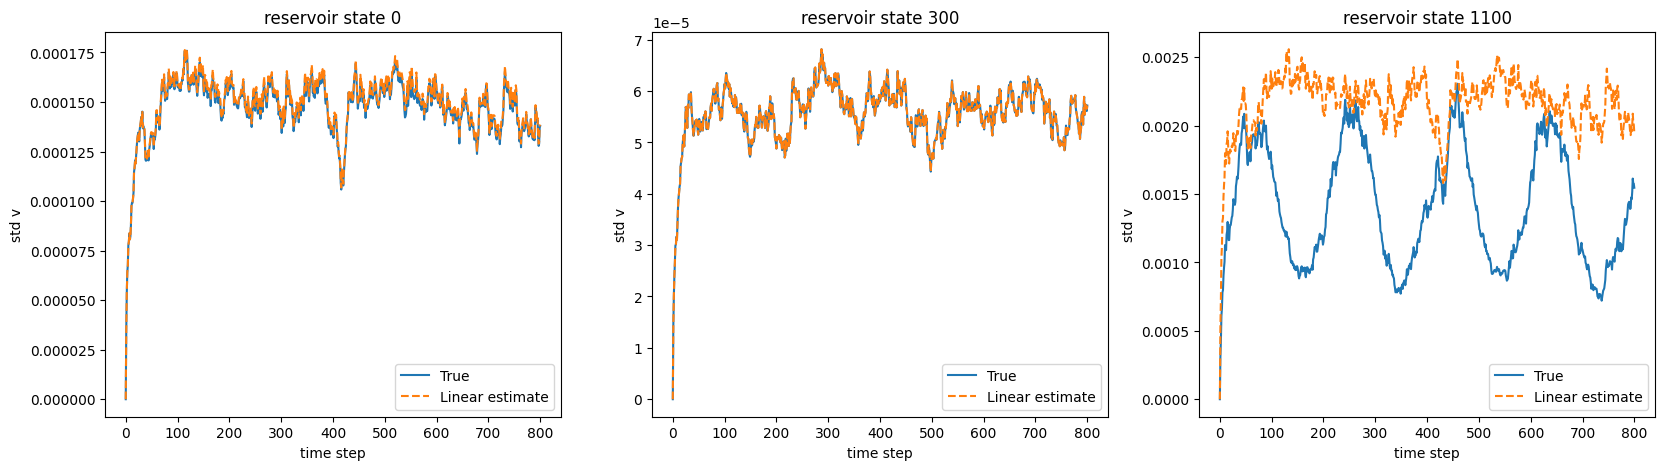

In [74]:
i = 0
plt.figure(figsize=(20,5))
for r_idx in r_idxs:
    i += 1
    plt.subplot(1,3,i)
    plt.plot(std_v_true[:,r_idx])
    plt.plot(std_v[:,r_idx],'--')
    plt.xlabel('time step')
    plt.ylabel('std v')
    plt.title(f'reservoir state {r_idx}')
    plt.legend(['True','Linear estimate'])

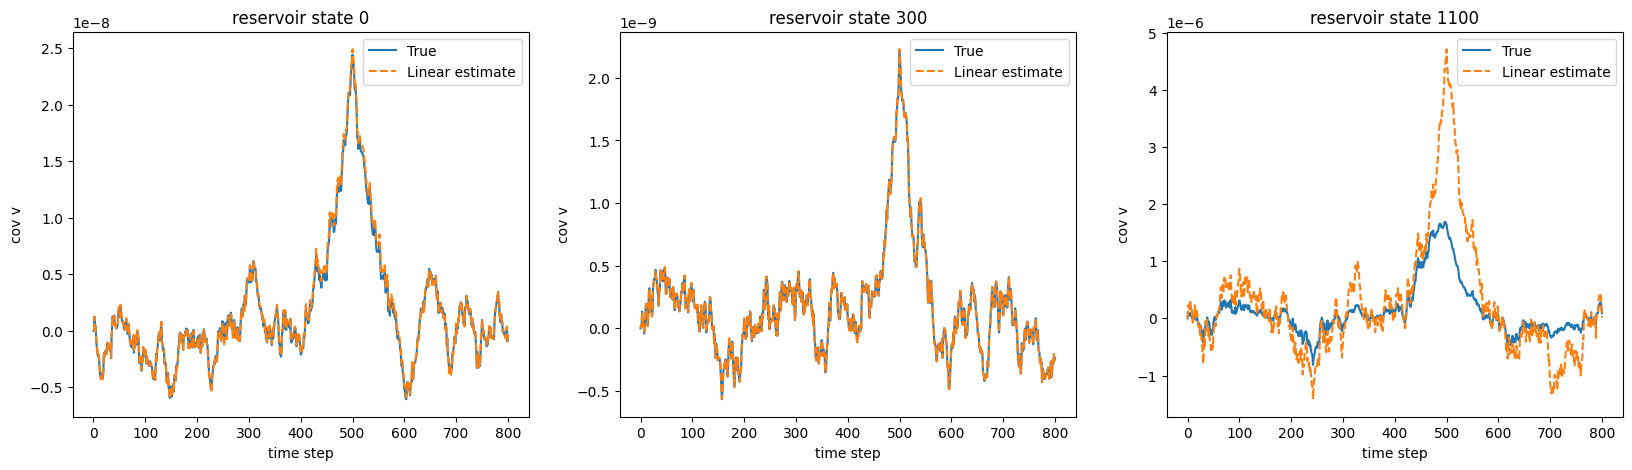

In [78]:
i = 0
plt.figure(figsize=(20,5))
for r_idx in r_idxs:
    # covariance is a tensor for each r, how is noise correlated at different times 
    cov_v_r = np.cov(v[:,:,r_idx].T)
    cov_v_true_r = np.cov(v_true[:,:,r_idx].T)
    i += 1
    plt.subplot(1,3,i)
    plt.plot(cov_v_true_r[:,500])
    plt.plot(cov_v_r[:,500],'--')
    plt.xlabel('time step')
    plt.ylabel('cov v')
    plt.title(f'reservoir state {r_idx}')
    plt.legend(['True','Linear estimate'])